# Flight Fare Prediction Project:
- Credits: MachineHack by Analytics India Magazine
- Data collected from **2019**

<img src="https://res.cloudinary.com/wegowordpress/images/f_auto,q_auto/v1589299940/shutterstock_559714906_auhzh1/shutterstock_559714906_auhzh1.jpg" width=500px></img><br>
---
<font size=4> Where are you departing from? ✈</font><br>
<font size=4> Where are you flying to?</font><br>
<font size=4> Is it a vacation season? </font> <font color='red'> Worried </font> about the prices?<br>
<font size=4> This code will predict it for you 😁</font><br>

## Step 0: Import libraries and describe data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import time
from datetime import time as dtime
%matplotlib inline

In [2]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [3]:
train = pd.read_excel('Data_Train.xlsx')
df = train.copy()
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
df.describe(include='all')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
count,10683,10683,10683,10683,10682,10683,10683,10683,10682,10683,10683.000000
unique,12,44,5,6,128,222,1343,368,5,10,NaN
top,Jet Airways,18/05/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info,NaN
freq,3849,504,4537,4537,2376,233,423,550,5625,8345,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9087.064121
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4611.359167
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5277.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8372.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12373.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


### Initial observations:
* **Date_of_Journey** is in a dd/mm/yyyy format but is parsed as object
* **Route** is a complex string that needs to be processed
* **Duration** is human-readable which should be converted to minutes
* **Total_Stops** does not align with the actual Route details which can be corrected
* **Arrival_Time** has ill-formatted data in places which should be addressed
* **Source and Destination** have inconsistent values for the same city which should be cleaned

## Step 1: Preprocessing and Feature Engineering

### Step 1.1: Cleaning Source and Destination

In [6]:
df['Source'].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [7]:
df['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [8]:
df['Source'].replace({
    'Banglore': 'Bangalore',
    'Delhi': 'New Delhi'
    }, inplace=True)

df['Destination'].replace({
    'Delhi': 'New Delhi',
    'Banglore': 'Bangalore'
}, inplace=True)

In [9]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Bangalore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Bangalore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,New Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Bangalore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Bangalore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Step 1.2: Time of Day of Departure

In [10]:
# def split_tod(x):
#     x = pd.to_datetime(x).time()
#     if x <= dtime(hour=9, minute=0):
#         return 'early_morning'
#     elif x <= dtime(hour=12, minute=0):
#         return 'morning'
#     elif x <= dtime(hour=18, minute=0):
#         return 'afternoon'
#     else:
#         return 'evening'

# assert split_tod('11:11')=='morning'
# assert split_tod('8:59')=='early_morning'
# assert split_tod('17:59')=='afternoon'
# assert split_tod('21:21')=='evening'

In [11]:
# df['time_of_dep'] = df['Dep_Time'].apply(split_tod)

### Step 1.3: Convert Stops

In [12]:
df['stops'] = df['Total_Stops'].replace({
    'non-stop': '0',
    '1 stop': '1',
    '2 stops': '2',
    '3 stops': '3',
    '4 stops': '4',
})

df['stops'].fillna('2', inplace=True)
df['stops'] = df['stops'].astype(object)

### Step 1.4: Explore Airlines

In [13]:
df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [14]:
# df['premium_econ'] = df['Airline'].apply(lambda x: 1 if 'Premium' in x else 0)
# df['business'] = df['Airline'].apply(lambda x: 1 if 'Business' in x else 0)

In [15]:
df['Airline'].replace({
    'Vistara Premium economy': 'PremiumEcon',
    'Multiple carriers Premium economy': 'PremiumEcon',
    'Multiple carriers': 'Other',
    'Jet Airways Business': 'Business',
    'Trujet': 'Other'
}, inplace=True)

In [16]:
df['Airline'].value_counts()

Jet Airways    3849
IndiGo         2053
Air India      1752
Other          1197
SpiceJet        818
Vistara         479
Air Asia        319
GoAir           194
PremiumEcon      16
Business          6
Name: Airline, dtype: int64

In [17]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,stops
0,IndiGo,24/03/2019,Bangalore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,0
1,Air India,1/05/2019,Kolkata,Bangalore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2
2,Jet Airways,9/06/2019,New Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2
3,IndiGo,12/05/2019,Kolkata,Bangalore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,1
4,IndiGo,01/03/2019,Bangalore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1


### Step 1.5: Flight Month

In [18]:
df['month'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.month
df['month'] = df['month'].apply(lambda x: f'M{str(x)}')

In [19]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,stops,month
0,IndiGo,24/03/2019,Bangalore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,0,M3
1,Air India,1/05/2019,Kolkata,Bangalore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2,M5
2,Jet Airways,9/06/2019,New Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2,M6
3,IndiGo,12/05/2019,Kolkata,Bangalore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,1,M5
4,IndiGo,01/03/2019,Bangalore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,M3


### Step 1.6: Weekend

In [20]:
df['weekend'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.day_of_week
df['weekend'] = df['weekend'].apply(lambda x: 1 if x in (5,6) else 0)

## Step 2: Prepare Data

### Step 2.1 Subset Data

In [21]:
df2 = df[['Airline', 
        'Source',
        'Destination',
        'stops',
        'month',
        'weekend',
        # 'time_of_dep',
        'Price']]
df2.head()

,Airline,Source,Destination,stops,month,weekend,Price
0,IndiGo,Bangalore,New Delhi,0,M3,1,3897
1,Air India,Kolkata,Bangalore,2,M5,0,7662
2,Jet Airways,New Delhi,Cochin,2,M6,1,13882
3,IndiGo,Kolkata,Bangalore,1,M5,1,6218
4,IndiGo,Bangalore,New Delhi,1,M3,0,13302


In [22]:
df2 = df2.convert_dtypes()

In [23]:
cat_ = df2.dtypes[df2.dtypes.values=='string'].keys().values
for col in cat_:
    df2[col] = df2[col].astype(object)
cat_

array(['Airline', 'Source', 'Destination', 'stops', 'month'], dtype=object)

In [24]:
df3 = pd.get_dummies(df2, drop_first=True)
df3['weekend'] = df3['weekend'].astype(int)

In [25]:
df3.head()

,weekend,Price,Airline_Air India,Airline_Business,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Other,Airline_PremiumEcon,Airline_SpiceJet,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,stops_1,stops_2,stops_3,stops_4,month_M4,month_M5,month_M6
0,1,3897,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,7662,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,13882,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,6218,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,13302,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


### Step 2.2: Split Data

In [26]:
X = df3.drop('Price', axis=1)
Y = np.array(df3['Price'].values).reshape(-1, 1)
print(X.shape, Y.shape)

(10683, 25) (10683, 1)


In [27]:
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=42)

## Step 3: Setup models

### Step 3.1: Set up functions

In [28]:
def timer(func):
    def wrapper(*args, **kwargs):
        tick = time.time()
        result = func(*args, **kwargs)
        tock = time.time()
        print(f"Time elapsed in minutes: {round((tock-tick)/60, 2)}")
        return result
    return wrapper

In [29]:
@timer
def fit_etc(X, Y, load=False):
    """
    Args:
        X: Dataframe of dummy encoded predictor variables
        Y: Series or Numpy array of target price
    Returns:
        grid search object model for ExtraTrees Regressor
    """
    etc = ExtraTreesRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 250, 500],
        'max_depth': [2, 4, 8],
        'min_samples_split': [5, 10, 50],  
        'min_samples_leaf': [4, 8]
    }
    cv = KFold(n_splits = 5)
    grid_search = GridSearchCV(
        estimator=etc,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_squared_error'
    )
    if load:
        with open('models/etc_grid.pkl', 'rb') as f:
            grid_search = pickle.load(f)
    else:
        grid_search.fit(X, Y)
        with open('models/etc_grid.pkl', 'wb') as f:
            pickle.dump(grid_search, f)
    return grid_search

@timer
def fit_rf(X, Y, load=False):
    """
    Args:
        X: Dataframe of dummy encoded predictor variables
        Y: Series or Numpy array of target price
    Returns:
        grid search object model for RandomForest Regressor
    """
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 250, 500],
        'max_depth': [2, 4, 8],
        'min_samples_split': [5, 10, 50],  
        'min_samples_leaf': [4, 8]
    }
    cv = KFold(n_splits = 5)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_squared_error'
    )
    if load:
        with open('models/rf_grid.pkl', 'rb') as f:
            grid_search = pickle.load(f)
    else:
        grid_search.fit(X, Y)
        with open('models/rf_grid.pkl', 'wb') as f:
            pickle.dump(grid_search, f)
    
    return grid_search

@timer
def fit_lgbm(X, Y, load=False):
    """
    Args:
        X: Dataframe of dummy encoded predictor variables
        Y: Series or Numpy array of target price
    Returns:
        grid search object model for LightGBM Regressor
    """
    lgbm = LGBMRegressor(random_state=42,)
    param_grid = {
        'n_estimators': [100, 250, 500],
        'max_depth': [2, 4, 8],
        'subsample': [0.25, 0.5, 0.75, 1],
        'reg_alpha': [0.25, 0.5, 0.75, 1]
    }
    cv = KFold(n_splits = 5)
    grid_search = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_squared_error'
    )
    if load:
        with open('models/lgbm_grid.pkl', 'rb') as f:
            grid_search = pickle.load(f)
    else:
        grid_search.fit(X, Y)
        with open('models/lgbm_grid.pkl', 'wb') as f:
            pickle.dump(grid_search, f)
    
    return grid_search


@timer
def fit_lasso(X, Y, load=False):
    """
    Args:
        X: Dataframe of dummy encoded predictor variables
        Y: Series or Numpy array of target price
    Returns:
        Lasso Regression object
    """
    lasso = Lasso(random_state=42)
    if load:
        with open('models/lasso.pkl', 'rb') as f:
            lasso = pickle.load(f)
    else:
        lasso.fit(X, Y)
        with open('models/lasso.pkl', 'wb') as f:
            pickle.dump(lasso, f)
    
    return lasso


### Step 3.2: Build Models

In [31]:
lasso_model = fit_lasso(xtrain, ytrain, load=False)

Time elapsed in minutes: 0.0


In [32]:
lgbm_model = fit_lgbm(xtrain, ytrain.ravel(), load=False)

Time elapsed in minutes: 2.26


In [33]:
etc_model = fit_etc(xtrain, ytrain.ravel(), load=False)

Time elapsed in minutes: 3.33


In [34]:
rf_model = fit_rf(xtrain, ytrain.ravel(), load=False)

Time elapsed in minutes: 2.87


### Step 3.3.2 Load Models

### Step 3.3: Evaluate Predictions on Validation set

In [35]:
Y_pred_etc = etc_model.predict(xval)
Y_pred_rf = rf_model.predict(xval)
Y_pred_lgbm = lgbm_model.predict(xval)
Y_pred_lasso = lasso_model.predict(xval)

In [36]:
print(np.sqrt(mean_squared_error(yval, Y_pred_etc)))
print(np.sqrt(mean_squared_error(yval, Y_pred_rf)))
print(np.sqrt(mean_squared_error(yval, Y_pred_lgbm)))
print(np.sqrt(mean_squared_error(yval, Y_pred_lasso)))

2927.1386532629467
2798.7617837401913
2650.4863166021414
2922.0788366896363


In [37]:
print(mean_absolute_percentage_error(yval, Y_pred_etc))
print(mean_absolute_percentage_error(yval, Y_pred_rf))
print(mean_absolute_percentage_error(yval, Y_pred_lgbm))
print(mean_absolute_percentage_error(yval, Y_pred_lasso))

0.20874250397632949
0.2045263442662567
0.19003293449835904
0.23751559728320482


In [38]:
print(mean_absolute_error(yval, Y_pred_etc))
print(mean_absolute_error(yval, Y_pred_rf))
print(mean_absolute_error(yval, Y_pred_lgbm))
print(mean_absolute_error(yval, Y_pred_lasso))

1844.9692462150608
1803.5689193318062
1706.2670098922845
2003.2850394023815


In [39]:
fimp = pd.DataFrame()
fimp['variable'] = xtrain.columns
fimp['rf_imp'] = rf_model.best_estimator_.feature_importances_
fimp['etc_imp'] = etc_model.best_estimator_.feature_importances_
fimp.sort_values(by='rf_imp', ascending=False, inplace=True)
fimp.reset_index(drop=True, inplace=True)

## Step 4: Evaluate predictions

### Step 4.1: Scoring on Train

In [39]:
rf_model.best_estimator_.score(xtrain, ytrain)

0.6357164618207747

In [40]:
etc_model.best_estimator_.score(xtrain, ytrain)

0.5938243578161049

In [41]:
lgbm_model.best_estimator_.score(xtrain, ytrain)

0.6770985675503765

In [42]:
lasso_model.score(xtrain, ytrain)

0.6166930823561092

### Step 4.2: Plot of difference

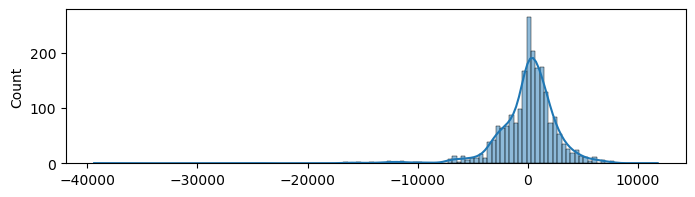

In [44]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.histplot(Y_pred_etc - yval.ravel(), kde=True, ax=ax)
plt.show()

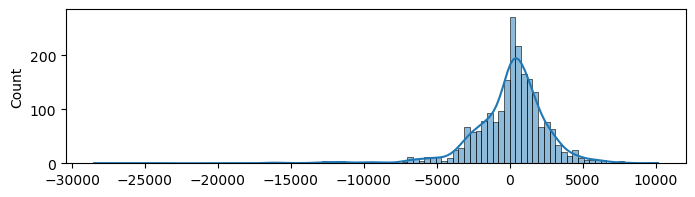

In [45]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.histplot(Y_pred_rf - yval.ravel(), kde=True, ax=ax)
plt.show()

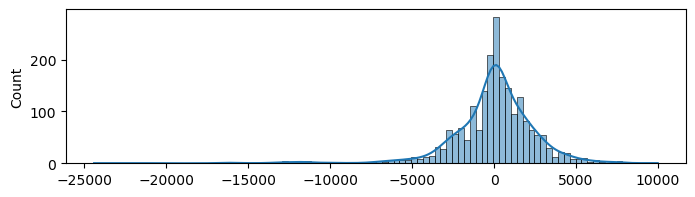

In [46]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.histplot(Y_pred_lgbm - yval.ravel(), kde=True, ax=ax)
plt.show()

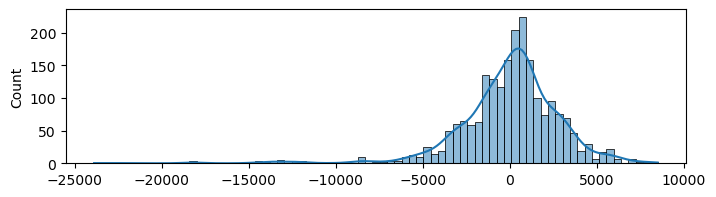

In [47]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.histplot(Y_pred_lasso - yval.ravel(), kde=True, ax=ax)
plt.show()

Text(0.5, 1.0, 'Scatter Plot of predictions - RF')

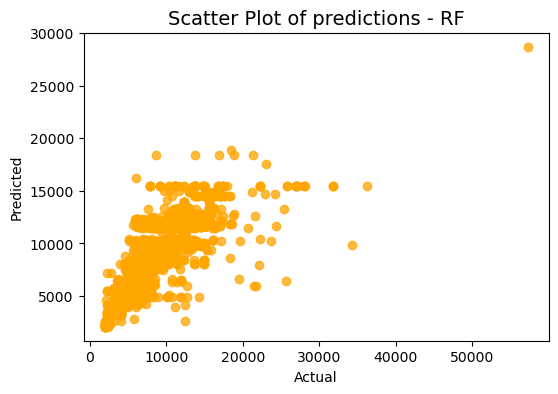

In [48]:
plt.figure(figsize=(6,4))
plt.scatter( yval, Y_pred_rf, color='orange', alpha=0.75)
plt.xlabel("Actual", size=10)
plt.ylabel("Predicted", size=10)
plt.title("Scatter Plot of predictions - RF", size=14)

Text(0.5, 1.0, 'Scatter Plot of predictions - ETC')

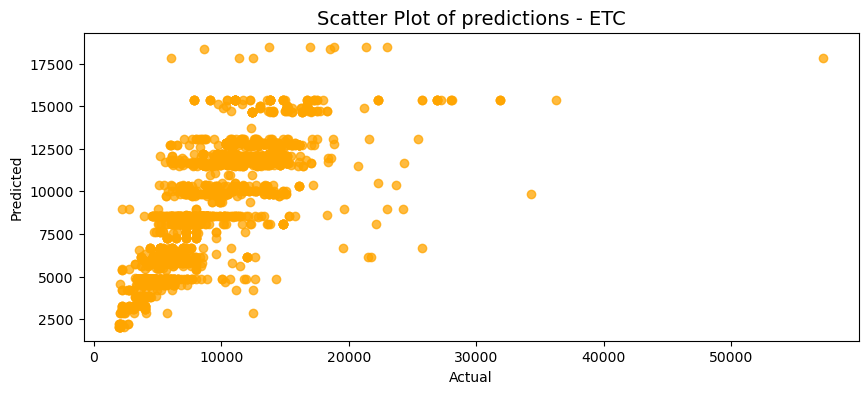

In [49]:
plt.figure(figsize=(10,4))
plt.scatter( yval, Y_pred_etc, color='orange', alpha=0.75)
plt.xlabel("Actual", size=10)
plt.ylabel("Predicted", size=10)
plt.title("Scatter Plot of predictions - ETC", size=14)

Text(0.5, 1.0, 'Scatter Plot of predictions - LGBM')

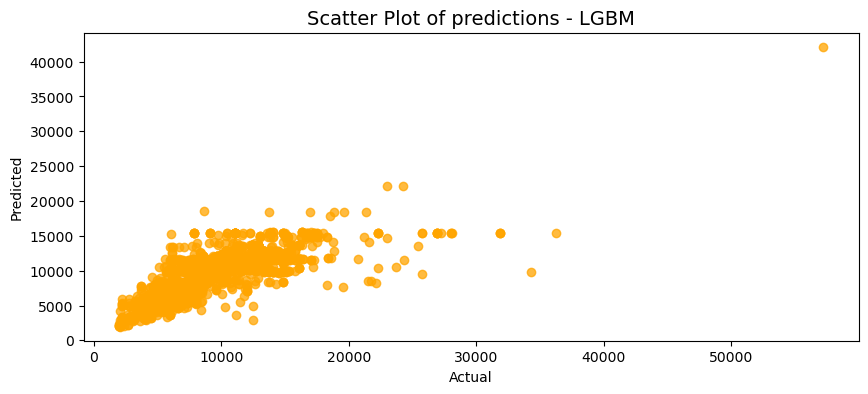

In [51]:
plt.figure(figsize=(10,4))
plt.scatter( yval, Y_pred_lgbm, color='orange', alpha=0.75)
plt.xlabel("Actual", size=10)
plt.ylabel("Predicted", size=10)
plt.title("Scatter Plot of predictions - LGBM", size=14)

Text(0.5, 1.0, 'Scatter Plot of predictions - Lasso')

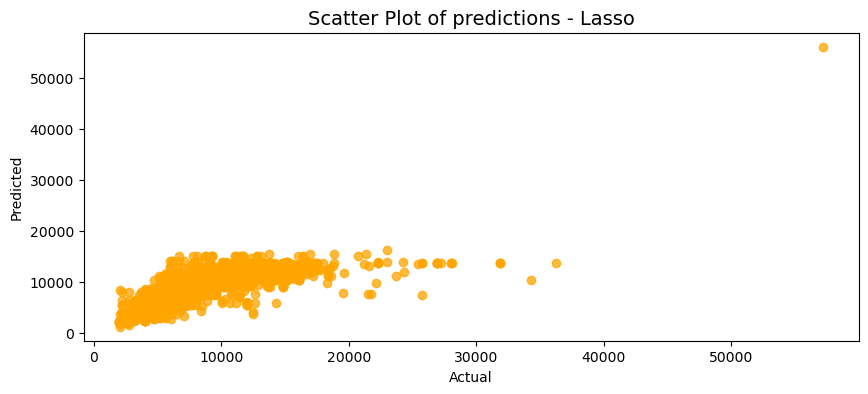

In [50]:
plt.figure(figsize=(10,4))
plt.scatter( yval, Y_pred_lasso, color='orange', alpha=0.75)
plt.xlabel("Actual", size=10)
plt.ylabel("Predicted", size=10)
plt.title("Scatter Plot of predictions - Lasso", size=14)

In [52]:
print(f"R-squared score for RF: {r2_score(yval, Y_pred_rf)}")
print(f"R-squared score for ETC: {r2_score(yval, Y_pred_etc)}")
print(f"R-squared score for LGBM: {r2_score(yval, Y_pred_lgbm)}")
print(f"R-squared score for Lasso: {r2_score(yval, Y_pred_lasso)}")

R-squared score for RF: 0.6298865958527509
R-squared score for ETC: 0.5951542979759001
R-squared score for LGBM: 0.6680642136727595
R-squared score for Lasso: 0.5965527110861222


## Step 5: Pre-processing & Setup

### Step 5.1: Define preprocessing function

In [53]:
def preprocess(dataframe):
    df = dataframe.copy()
    """
    Args: 
        df: dataframe

    Returns: 
        processed dataframe with dummy variables
    """

    # Step 1: Clean Source
    df['Source'].replace(
        {'Banglore': 'Bangalore','Delhi': 'New Delhi'},
    inplace=True)
    
    # Step 2: Clean Destination
    df['Destination'].replace(
        {'Delhi': 'New Delhi','Banglore': 'Bangalore'},
    inplace=True)

    # Step 3: Feature engineer stops
    df['stops'] = df['Total_Stops'].replace({
        'non-stop': '0',
        '1 stop': '1',
        '2 stops': '2',
        '3 stops': '3',
        '4 stops': '4',
    })
    df['stops'].fillna(df['stops'].mode(), inplace=True)
    df['stops'] = df['stops'].astype(object)
    df.drop("Total_Stops", axis=1, inplace=True)

    # Step 4: Clean Airline Options
    df['Airline'].replace({
        'Vistara Premium economy': 'PremiumEcon',
        'Multiple carriers Premium economy': 'PremiumEcon',
        'Multiple carriers': 'Other',
        'Jet Airways Business': 'Business',
        'Trujet': 'Other'
    }, inplace=True)

    # Step 5: Calculate month of flight
    df['month'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').\
    dt.month
    df['month'] = df['month'].apply(lambda x: f'M{str(x)}')

    # Step 6: Calculate weekend
    df['weekend'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').\
    dt.day_of_week
    df['weekend'] = df['weekend'].apply(lambda x: 1 if x in (5,6) else 0)
    
    # Step 7: Convert to dummy variables
    dfr = df[['Airline', 'Source', 'Destination', 'stops', 'month', 'weekend', 
              'Price']].copy()

    dfr = dfr.convert_dtypes()
    
    cat_ = dfr.dtypes[dfr.dtypes.values=='string'].keys().values
    for col in cat_:
        dfr[col] = dfr[col].astype(object)
    
    return pd.get_dummies(dfr, drop_first=True)

In [54]:
assert not set(X.columns).difference(set(preprocess(train).columns))

In [55]:
xtrain.columns

Index(['weekend', 'Airline_Air India', 'Airline_Business', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Other',
       'Airline_PremiumEcon', 'Airline_SpiceJet', 'Airline_Vistara',
       'Source_Chennai', 'Source_Kolkata', 'Source_Mumbai', 'Source_New Delhi',
       'Destination_Cochin', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi', 'stops_1', 'stops_2', 'stops_3', 'stops_4',
       'month_M4', 'month_M5', 'month_M6'],
      dtype='object')

In [56]:
rf_model.feature_names_in_

array(['weekend', 'Airline_Air India', 'Airline_Business',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Other', 'Airline_PremiumEcon', 'Airline_SpiceJet',
       'Airline_Vistara', 'Source_Chennai', 'Source_Kolkata',
       'Source_Mumbai', 'Source_New Delhi', 'Destination_Cochin',
       'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi', 'stops_1', 'stops_2', 'stops_3',
       'stops_4', 'month_M4', 'month_M5', 'month_M6'], dtype=object)

### Step 5.2: Export Models

In [57]:
with open('rf_grid.pkl', 'wb') as f:
    pickle.dump(rf_model.best_estimator_, f)

In [58]:
with open('etc_grid.pkl', 'wb') as f:
    pickle.dump(etc_model.best_estimator_, f)

In [59]:
with open('lgbm_grid.pkl', 'wb') as f:
    pickle.dump(lgbm_model.best_estimator_, f)

In [60]:
with open('lasso.pkl', 'wb') as f:
    pickle.dump(lasso_model, f)